# Homework 01-intro

Jaime Cabrera-Salcedo

[https://www.linkedin.com/in/jaimeh94/](https://www.linkedin.com/in/jaimeh94/)

In [33]:
!python -V

Python 3.9.7


In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

## Question 1 

Downloading the data:

In [35]:
df = pd.read_parquet('./data/fhv_tripdata_2021-01.parquet')
df

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037
...,...,...,...,...,...,...,...
1154107,B03266,2021-01-31 23:43:03,2021-01-31 23:51:48,7.0,7.0,None,B03266
1154108,B03284,2021-01-31 23:50:27,2021-02-01 00:48:03,44.0,91.0,None,
1154109,B03285,2021-01-31 23:13:46,2021-01-31 23:29:58,171.0,171.0,None,B03285
1154110,B03285,2021-01-31 23:58:03,2021-02-01 00:17:29,15.0,15.0,None,B03285


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1154112 entries, 0 to 1154111
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   dispatching_base_num    1154112 non-null  object        
 1   pickup_datetime         1154112 non-null  datetime64[ns]
 2   dropOff_datetime        1154112 non-null  datetime64[ns]
 3   PUlocationID            195845 non-null   float64       
 4   DOlocationID            991892 non-null   float64       
 5   SR_Flag                 0 non-null        object        
 6   Affiliated_base_number  1153227 non-null  object        
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 61.6+ MB


Read the data for January. How many records are there?

**Answer:** There are 1154112 records

## Question 2

Computing Duration

In [37]:
df['duration'] = df.dropOff_datetime - df.pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df.duration.mean()

19.1672240937939

What's the average trip duration in January?

**Answer:**  19.16 minutes

Date preparation
---

Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

In [38]:
df.duration.describe()

count    1.154112e+06
mean     1.916722e+01
std      3.986922e+02
min      1.666667e-02
25%      7.766667e+00
50%      1.340000e+01
75%      2.228333e+01
max      4.233710e+05
Name: duration, dtype: float64

<AxesSubplot:>

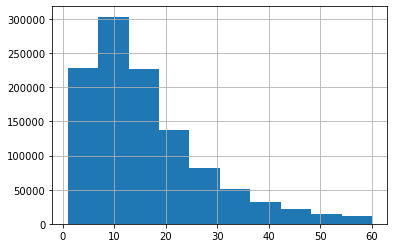

In [39]:
df = df[(df.duration >= 1) & (df.duration <= 60)]
df.duration.hist()

## Question 3

Missing values

In [40]:
df[['PUlocationID','DOlocationID']] = df[['PUlocationID','DOlocationID']].fillna(-1)
(df.PUlocationID == -1).mean()

/tmp/ipykernel_23916/64339548.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['PUlocationID','DOlocationID']] = df[['PUlocationID','DOlocationID']].fillna(-1)


0.8352732770722617

What's the fractions of missing values for the pickup location ID? I.e. fraction of "-1"s after you filled the NAs.

**Answer:** 83%

## Question 4

One-hot encoding

In [41]:
categorical = ['PUlocationID', 'DOlocationID']
df[categorical] = df[categorical].astype(str)
train_dict = df[categorical].to_dict(orient='records')

/tmp/ipykernel_23916/3122109030.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


In [42]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dict)

In [46]:
X_train

<1109826x525 sparse matrix of type '<class 'numpy.float64'>'
	with 2219652 stored elements in Compressed Sparse Row format>

What's the dimensionality of this matrix? (The number of columns).

**Answer:** 525 columns

## Question 5

Training a model

In [47]:
target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

10.528519107205875

What's the RMSE on train?

**Answer:** 10.52

## Question 5

Evaluating the model with Feb dataset

In [51]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PUlocationID', 'DOlocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [52]:
df_train = read_dataframe('./data/fhv_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/fhv_tripdata_2021-02.parquet')

In [53]:
dv = DictVectorizer()

train_dicts = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [54]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [55]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

11.01428319218795

What's the RMSE on validation?

**Answer:** 11.01